In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xgcm
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)

w = cluster.start_workers(3)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [8]:
client

Client Scheduler: tcp://10.148.0.226:58479 Dashboard: http://10.148.0.226:8787/status,Cluster Workers: 2 Cores: 8 Memory: 100.00 GB


___________


In [9]:
out_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/zarr_file/'
out_dir_mooring = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/cross/'

In [10]:
lat_real_mooring = xr.DataArray([ 48.6875,  48.6940,  48.7480,  48.7000,  48.7485,  48.6803,  48.6290,  48.6780,  48.6290], dims='mooring')
lon_real_mooring = xr.DataArray([-16.1875, -16.1740, -16.0945, -16.2060, -16.2762, -16.1740, -16.0990, -16.2050, -16.2775], dims='mooring')

In [11]:
# C, N-I,N-O, W-I, W-O, E-I, E-O, S-I, S-O

inner = 0.0125
outer = 0.075
lat_C = 48.6875
lon_C = -16.1875

lat_mooring = xr.DataArray([lat_C, lat_C+inner, lat_C+outer, lat_C,       lat_C,       lat_C,       lat_C,       lat_C-inner, lat_C-outer], dims='mooring')
lon_mooring = xr.DataArray([lon_C, lon_C,       lon_C,       lon_C-inner, lon_C-outer, lon_C+inner, lon_C+outer, lon_C,       lon_C    ], dims='mooring')

# T

In [12]:
ds_T = xr.open_zarr(out_dir_zarr+'Theta_total_rechunk.zarr')
print(ds_T)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
Dimensions without coordinates: time
Data variables:
    Theta    (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(9415, 1, 201, 177)>


In [34]:
ds = xr.open_mfdataset(out_dir_mooring+'T_mooring.nc')
ds

<xarray.Dataset>
Dimensions:  (depth: 52, mooring: 9, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
    lon      (mooring) float32 dask.array<shape=(9,), chunksize=(9,)>
Dimensions without coordinates: mooring, time
Data variables:
    Theta    (time, depth, mooring) float32 dask.array<shape=(9415, 52, 9), chunksize=(9415, 52, 9)>

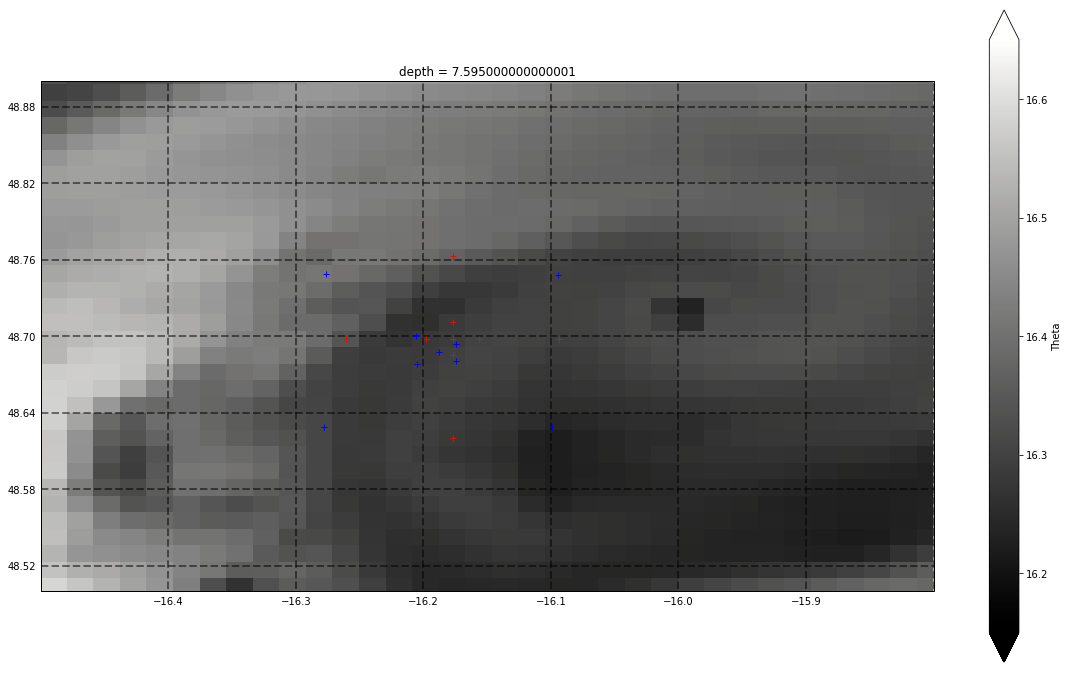

In [35]:
font_size = 24
tem = ds_T['Theta'].isel(depth=5,time=8000) 

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tem.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cm.gray, vmin= 16.15, vmax=16.65)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False


ax.plot(lon_real_mooring,lat_real_mooring, 'b+','markersize',24)
#ax.plot(T_mooring_site.lon,T_mooring_site.lat, 'r+')
ax.plot(ds.lon,ds.lat, 'r+', linewidth=2)

ax.set_xlim([-16.5,-15.8]);
ax.set_ylim([48.5,48.9]);

#ax.tick_params(labelsize=font_size)

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/data_store/Figure_1.png')



In [20]:
grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_store/Grid.nc', decode_coords=True)

ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')

ds = xr.merge([ds_U,ds_V,grid])
print(ds)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat_g    (lat_g) float32 47.39811 47.41132 47.424526 47.43773 47.45093 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon_g    (lon_g) float32 -18.041666 -18.020834 -18.0 -17.979166 ...
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    dxC      (lat, lon_g) float32 ...
    dyC      (lat_g, lon) float32 ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
Data variables:


In [21]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}})
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon (177) --> left
  * left     lon_g (177) --> center
Y Axis (periodic):
  * center   lat (201) --> left
  * left     lat_g (201) --> center


In [22]:
ds_U_ji = gridx.interp(ds['U'],axis='Y') 
ds_U_ji = np.real(ds_U_ji).rename('U')
ds_U_ji = ds_U_ji.to_dataset()
print(ds_U_ji)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
Data variables:
    U        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(9415, 1, 200, 177)>


In [23]:
ds_V_ji = gridx.interp(ds_V['V'],axis='X') 
ds_V_ji = np.real(ds_V_ji).rename('V')
ds_V_ji = ds_V_ji.to_dataset()
print(ds_V_ji)

<xarray.Dataset>
Dimensions:  (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
  * lat      (lat) float32 47.404716 47.417923 47.43113 47.444332 47.45753 ...
  * lon      (lon) float32 -18.03125 -18.010416 -17.989584 -17.96875 ...
Data variables:
    V        (time, depth, lat, lon) float32 dask.array<shape=(9415, 52, 201, 177), chunksize=(9415, 1, 201, 176)>


In [28]:
out_dir_mooring_random = '/home1/datawork/xyu/OSMOSIS_llc4320/data_store/random_location/'

ds = xr.open_mfdataset(out_dir_mooring_random+'U_mooring_random.nc')
ds

<xarray.Dataset>
Dimensions:  (depth: 52, location: 40, mooring_array: 5, time: 9415)
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 0.1667 0.2083 0.25 ...
  * depth    (depth) float64 0.5 1.57 2.79 4.185 5.78 7.595 9.66 12.01 14.68 ...
    lat      (mooring_array, location) float32 dask.array<shape=(5, 40), chunksize=(5, 40)>
    lon      (mooring_array, location) float32 dask.array<shape=(5, 40), chunksize=(5, 40)>
Dimensions without coordinates: location, mooring_array
Data variables:
    U        (time, depth, mooring_array, location) float32 dask.array<shape=(9415, 52, 5, 40), chunksize=(9415, 52, 5, 40)>

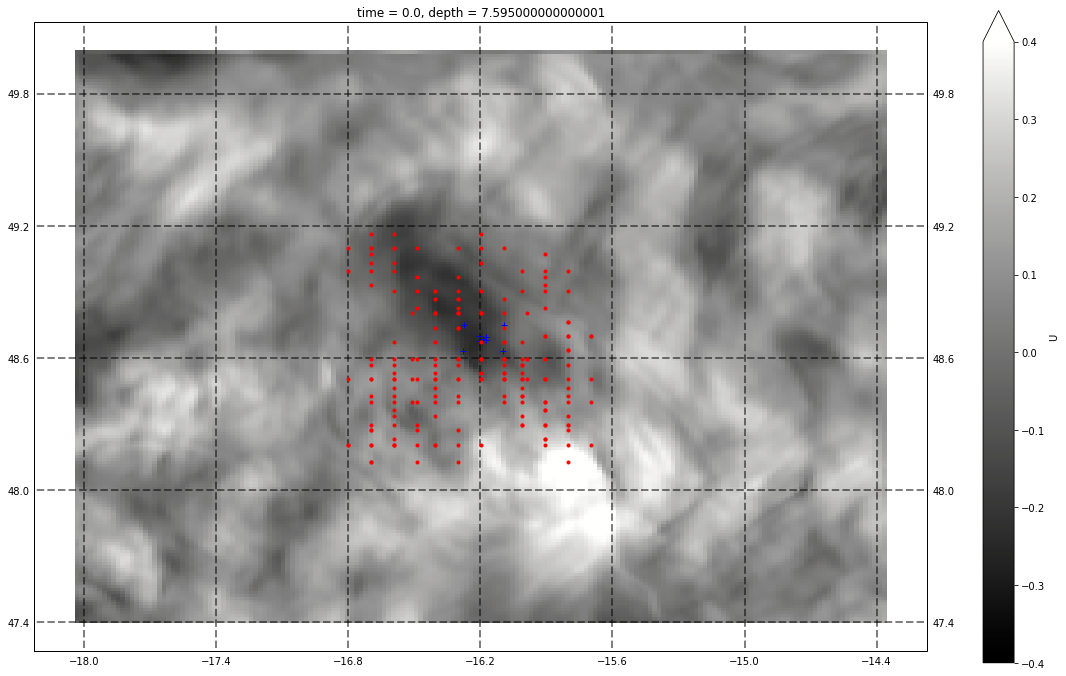

In [33]:
tem = ds_U_ji['U'].isel(depth=5,time=0) 

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
tem.plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cm.gray, vmin=-0.4, vmax=0.4)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False

ax.plot(lon_real_mooring,lat_real_mooring, 'b+')
#ax.plot(U_mooring_site.lon,U_mooring_site.lat, 'r+')

ax.plot(ds.lon,ds.lat, 'r.')


#ax.set_xlim([-15.6,-17.0]);
#ax.set_ylim([48,49.2]);

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/data_store/Figure_2.png')


In [30]:
cluster.scheduler.close()

<Future finished result=None>